<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Общий-анализ" data-toc-modified-id="Общий-анализ-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Общий анализ</a></span></li><li><span><a href="#В-рамках-недели" data-toc-modified-id="В-рамках-недели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>В рамках недели</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Начнём, конечно, с импортов.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

Прочитаем файлы, запарсим даты и сделаем их индексом.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Отсортируем по возрастающей.

In [3]:
data.sort_index(inplace=True)

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Ресемплируем данные по одному часу.

In [5]:
data = data.resample('1H').sum()

In [6]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Похоже на правду.

## Анализ

### Общий анализ

Для начала посмотрим на тренды и сезонность по всем данным. 

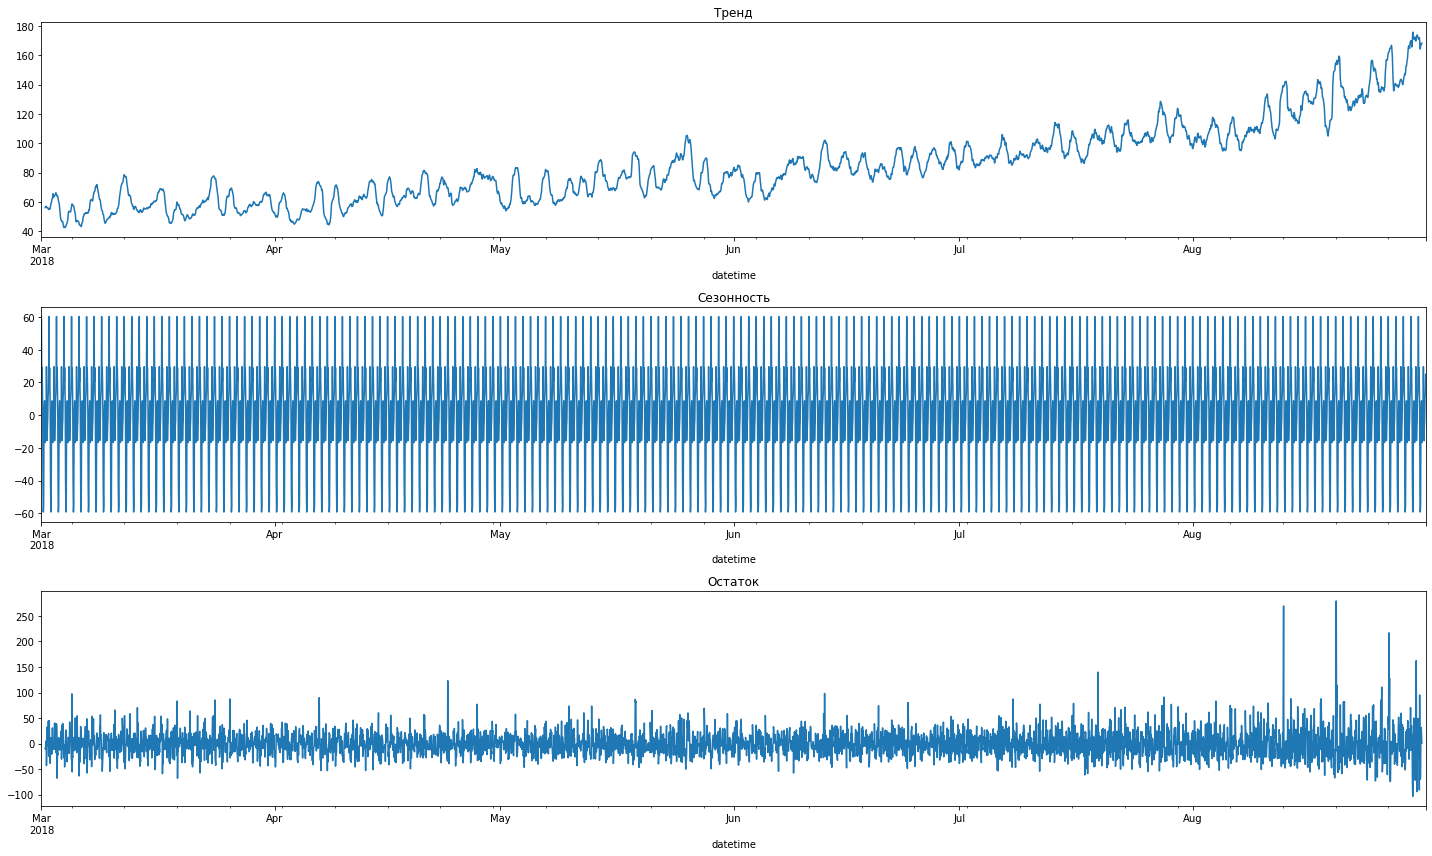

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(20, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

Что же мы видим? Спрос на услуги компании растёт с каждым месяцем. Учитывая, что заказы из аэропорта, это свидетельствует о том, что чем ближе летом, тем чаще люди куда-то летают. Невероятный вывод, я знаю.

### В рамках недели

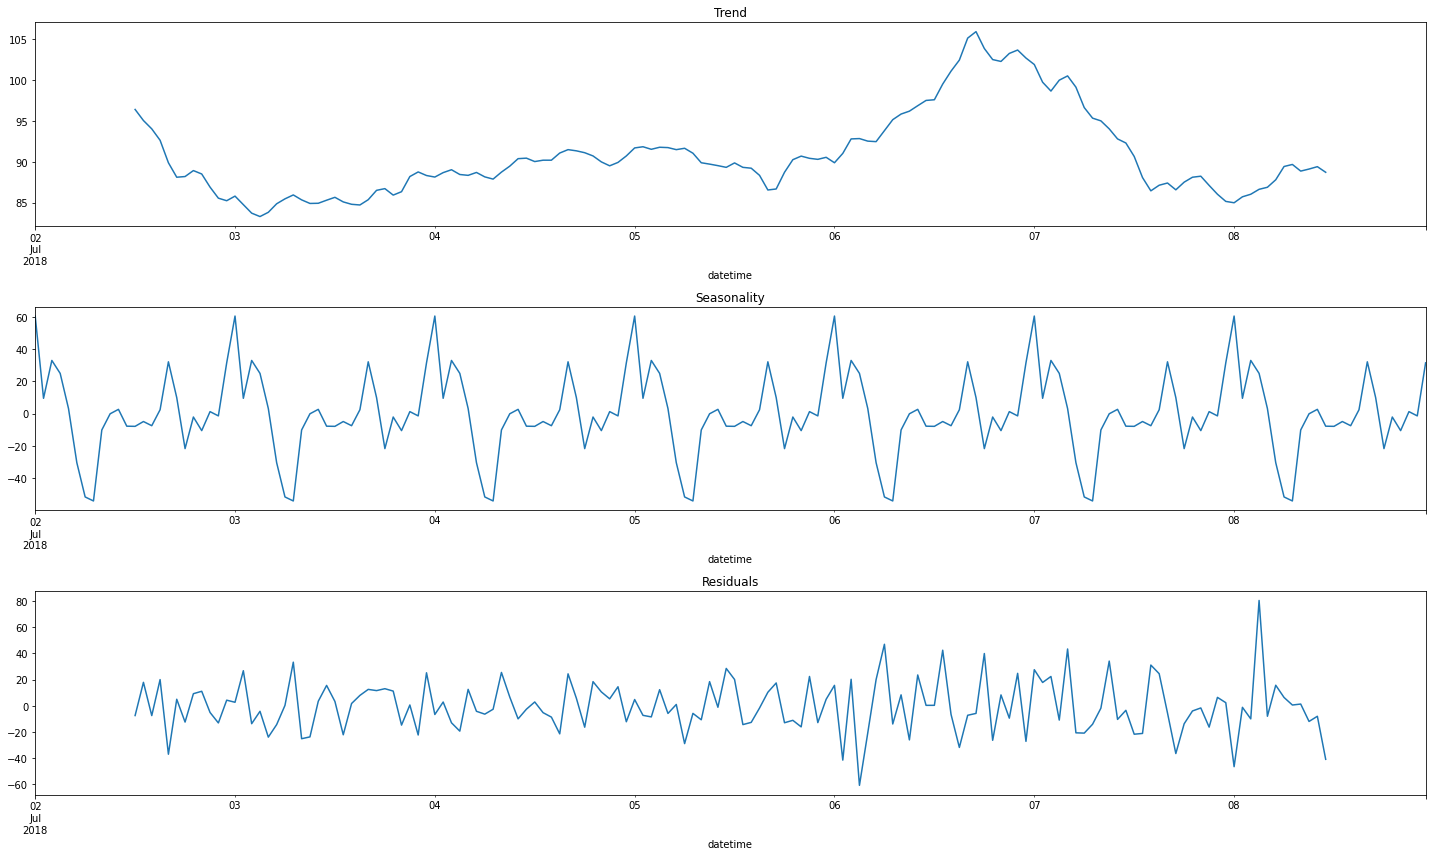

In [8]:
data_week = data['2018-07-02':'2018-07-08']
decomposed = seasonal_decompose(data_week)

plt.figure(figsize=(20, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Здесь мы видим, что пик количества вызовов - это день перед выходными и первый выходной.

Посмотрел также данные по дню и месяцу, но ничего любопытного в них не увидел.

Построим на всякий случай гистограмму плотности по количеству вызовов, чтобы посмотреть есть ли вбросы.

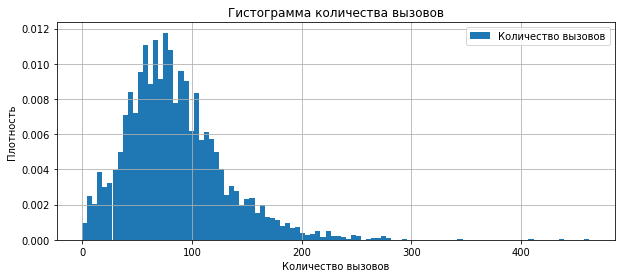

In [9]:
data['num_orders'].hist(bins = 100, density = 'True', label = 'Количество вызовов', alpha = 1, figsize = (10, 4))

plt.xlabel('Количество вызовов')
plt.ylabel('Плотность')
plt.title('Гистограмма количества вызовов')
plt.legend()
plt.show()

In [10]:
data[data['num_orders'] < 50]

,num_orders
datetime,
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34
...,...
2018-08-29 06:00:00,36
2018-08-30 06:00:00,13
2018-08-30 07:00:00,39


In [11]:
data[data['num_orders'] > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


400 вызовов в 2 часа ночи? Интересные данные. Сначала я их удалил, но потом подумал, что учитывая в периодичность раз в неделю, это похоже на прилет большого рейса из какой-то карибской страны.

## Обучение

Для начала нужно больше признаков. Применим волшебную функцию для подготовки данных.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Попробуем подобрать параметры.

In [13]:
make_features(data, 10, 24)

Разделим датасет согласно условию задачи.

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
features_train = train.drop('num_orders', axis = 1)
features_test = test.drop('num_orders', axis = 1)

target_train = train['num_orders']
target_test = test['num_orders']

Перейдём к самим моделям.<br>
Возьмём линейную регресию, случайный лес и CatBoost.

In [16]:
linear_model = LinearRegression().fit(features_train, target_train)

In [17]:
tree_model = RandomForestRegressor()

Подберём параметры для дерева.

In [18]:
parameters = {'max_depth': range(2, 21, 2), 'n_estimators': range(9, 21, 2)}
tree_GS = GridSearchCV(tree_model, param_grid = parameters, scoring = 'neg_root_mean_squared_error')
tree_GS.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 21, 2),
                         'n_estimators': range(9, 21, 2)},
             scoring='neg_root_mean_squared_error')

In [19]:
tree_GS.best_params_

{'max_depth': 20, 'n_estimators': 19}

Сделаем тоже самое для CatBoost.

In [20]:
cat_model = CatBoostRegressor()

In [21]:
parameters = {'iterations': range(11, 31), 'depth': range(2, 9)}
cat_GS = GridSearchCV(cat_model, param_grid = parameters, scoring = 'neg_root_mean_squared_error')
cat_GS.fit(features_train, target_train, silent=True)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f1fd60833a0>,
             param_grid={'depth': range(2, 9), 'iterations': range(11, 31)},
             scoring='neg_root_mean_squared_error')

In [22]:
cat_GS.best_params_

{'depth': 4, 'iterations': 30}

Отлично, переходим к тестированию.

## Тестирование

### Линейная регрессия

In [32]:
print('RMSE линейной модели:', sqrt(mean_squared_error(target_test, linear_model.predict(features_test))))

RMSE линейной модели: 50.332173445537734


### Случайный лес

In [33]:
tree_model = RandomForestRegressor(random_state = 123456, max_depth = 16, n_estimators = 19).fit(features_train, target_train)
print('RMSE модели случайного леса:', sqrt(mean_squared_error(target_test, tree_model.predict(features_test))))

RMSE модели случайного леса: 43.30995105631575


Ура, 43.3

### CatBoost

In [34]:
cat_model = CatBoostRegressor(random_state = 123456, depth = 7, iterations = 30).fit(features_train, target_train)
print('RMSE модели CatBoost:', sqrt(mean_squared_error(target_test, cat_model.predict(features_test))))

Learning rate set to 0.5
0:	learn: 30.6705379	total: 5.67ms	remaining: 164ms
1:	learn: 27.2486926	total: 10.7ms	remaining: 150ms
2:	learn: 25.5807702	total: 18.4ms	remaining: 165ms
3:	learn: 25.2498737	total: 25.3ms	remaining: 164ms
4:	learn: 24.3646152	total: 37.5ms	remaining: 187ms
5:	learn: 23.5764251	total: 42.3ms	remaining: 169ms
6:	learn: 23.4033053	total: 46.9ms	remaining: 154ms
7:	learn: 22.7514769	total: 52ms	remaining: 143ms
8:	learn: 22.4966536	total: 56.4ms	remaining: 132ms
9:	learn: 22.3091779	total: 60.8ms	remaining: 122ms
10:	learn: 22.0677665	total: 67.5ms	remaining: 117ms
11:	learn: 21.9466141	total: 71.9ms	remaining: 108ms
12:	learn: 21.7465832	total: 78.3ms	remaining: 102ms
13:	learn: 21.3919070	total: 85.5ms	remaining: 97.7ms
14:	learn: 21.1070651	total: 96.1ms	remaining: 96.1ms
15:	learn: 21.0730115	total: 103ms	remaining: 89.9ms
16:	learn: 20.8158081	total: 110ms	remaining: 84ms
17:	learn: 20.4975203	total: 117ms	remaining: 78.1ms
18:	learn: 20.1945713	total: 125m

Проанализируем результаты:

In [35]:
predictions = pd.Series(tree_model.predict(features_test), index = target_test.index)

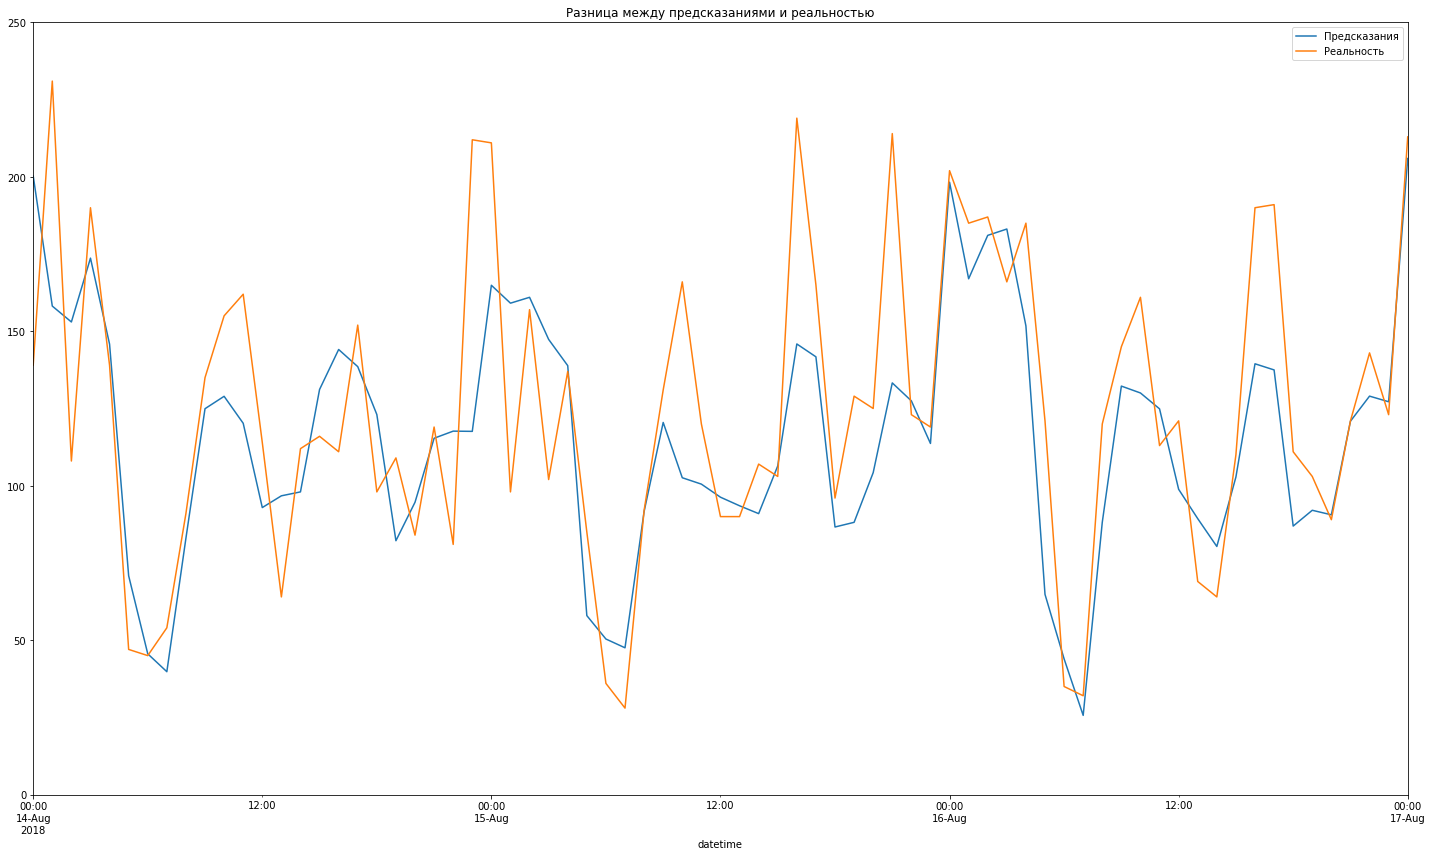

In [36]:
plt.figure(figsize=(20, 12))

plt.title('Разница между предсказаниями и реальностью')
predictions.plot(label = 'Предсказания')
target_test.plot(label = 'Реальность')
plt.xlim(['2018-08-14','2018-08-17'])
plt.ylim([0, 250])
plt.legend()
plt.tight_layout()

Похоже, модель плохо работает с пиковым значения в различное время дня. Простои она предсказывает неплохо.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

## Выводы

В результате выполнения проекта построены модели для прогнозирования необходимого количества такси на следующий час из аэропорта для компании "Чётенькое такси".<br>
Проанализированы исторические данные. Спрос на такси увеличивается в зависимости от близости сезона отпусков. В рамках недели пик приходится на пятницу и субботу.<br>
Обучены модели линейной регрессии, случайного дерева И CatBoost. Подобраны оптимальные параметры для случайного дерева и CatBoost. Исходные данные разделены на обучающие и тестовые в соотношение 9 к 1. <br>

Целью стояло подготовить модель с RMSE менее 48.<br>
С данной задачью справилась модель случайного дерева и CatBoost.<br>

RMSE модели случайного дерева: 43.73 <br>
RMSE модели линейной регрессии: 50.3<br>
RMSE модели CatBoost: 46.2<br>